University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  

# Week 1 exercises

In [1]:
# Useful imports
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from scipy.special import gammaln
from scipy.linalg import solve_triangular, cholesky

import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.grid'] = True

rng = npr.default_rng(42)

## 1. Input ranges for overflow and underflow (4 pts)

i. Write a program to find the largest integer for which `exp()` over double precision floating point numbers (`float64`) returns a finite value.

ii. The logistic function $$ \phi(x) = \frac{1}{1 + \exp(-x)} $$ is often used to map the real line to probabilities in the range $(0, 1)$, for example in logistic regression. For real numbers, the equation $ \phi(x) = 1 $ has no solution, but the same is not true for floating point numbers on a computer. Write a program to determine the smallest integer $ x $ for which $ \phi(x) =_F 1$ when using double precision floating point (`float64`) arithmetic.

*Note*: "Write a program" means you should not try out all values manually, but program the computer to find the solution.

In [2]:
# i)
def largest_valid_exp_argument() -> int:
    # we know that np.exp(1) is valid and np.exp(1000) is an overflow, so binary search
    minn, maxx = 1, 1000
    target = np.ceil((minn/maxx)/2)
    while(True):
        if target == maxx:
            return int(minn) # our we tried to go up, but reached maxx. So minn is the correct result.
        result = np.exp(target)
        if np.isinf(result): # go down
            maxx = target
            target = np.ceil((minn+target)/2)
            
        else: # go up
            minn = target
            target = np.ceil((target+maxx)/2)
    

largest_exp_x = largest_valid_exp_argument()
assert not np.isinf(largest_exp_x)
print(f"Largest value of x for which `exp(x)` is valid: {largest_exp_x}")

# ii

def logistic(x: np.float_) -> np.float_:
    return (
        1 / (
            1 + np.exp(-x)
        )
    )

def find_logistic_outputs_1() -> np.int_:
    minn, maxx = 0, 1_000_000
    target = np.ceil((minn/maxx)/2)
    while(True):
        if target == maxx:
            return int(maxx)
        result = logistic(target)
        if np.equal(result, 1.0): # go down
            maxx = target
            target = np.ceil((minn+target)/2)
            
        else: # go up
            minn = target
            target = np.ceil((target+maxx)/2)

smallest_logistic_x = find_logistic_outputs_1()
assert not np.isinf(smallest_logistic_x)
print(f"Smallest value of x for which `logistic(x)`=1: {smallest_logistic_x}")

Largest value of x for which `exp(x)` is valid: 709
Smallest value of x for which `logistic(x)`=1: 37


/var/folders/h7/h1t9twn9577g_ykyc9r8cprr0000gn/T/ipykernel_49587/1997148012.py:9: RuntimeWarning: overflow encountered in exp
  result = np.exp(target)


## 2. Numerical computation of binomial probabilities (4 pts)

Write a computer program to compute sums of binomial probabilities:
$$ f(l, u, n, p) = \sum_{i=l}^u \binom{n}{i} p^i (1-p)^{n-i}. $$
Use it to compute:

i. $ f(0, 5, 10, 0.25) = \sum_{i=0}^{5} \binom{10}{i} 0.25^i 0.75^{10-i} $

ii. $ f(10, 20, 20, 0.25) = \sum_{i=10}^{20} \binom{20}{i} 0.25^i 0.75^{20-i} $

iii. $ f(40, 60, 100, 0.25) = \sum_{i=40}^{60} \binom{100}{i} 0.25^i 0.75^{100-i} $

iv. $ f(75, 100, 100, 0.25) = \sum_{i=75}^{100} \binom{100}{i} 0.25^i 0.75^{100-i} $

*Hint*: Remember to use log probabilities and `logsumexp` as appropriate.

In [3]:

def f(l, u, n, p):
    l_u = np.arange(start=l, stop=u+1)

    # compute the binom coeff
    n_coeff = gammaln(n+1)
    k_coeff = gammaln(l_u+1)
    nk_coeff = gammaln(n-l_u+1)
    log_binom_coeff = n_coeff - (k_coeff + nk_coeff)

    # first term
    _p = np.multiply(l_u, np.log(p))
    eps = np.finfo(float).eps
    # we need to add a small constant here or we'll end up doing np.log(0)
    # I guess you could avoid this when doing the computation iteratively
    # but I want to use vectorized operations
    _p_prime = np.multiply(np.log(n-l_u+eps), np.log(1-p))

    log_binom_pmf = log_binom_coeff + _p + _p_prime
    m = np.max(log_binom_pmf)

    # logsumexp and normalisation
    return np.exp( log_binom_pmf - (m + np.log(np.sum(np.exp(log_binom_pmf-m))) ))

res1 = f(0, 5, 10, 0.25)
res2= f(10, 20, 20, 0.25)
res3= f(40, 60, 100, 0.25)
res4= f(75, 100, 100, 0.25)

for res in [res1, res2, res3, res4]:
    print(np.sum(res))


1.0000000000000002
1.0
0.9999999999999996
1.0000000000000013


## 3. Numerical evaluation of multivariate normal probabilities (4 pts)

Consider the $d$-variate normal distribution $\mathcal{N}(x;\; \mu, \Sigma)$ with the log-probability density
$$ \ln p(x;\; \mu, \Sigma) = -\frac{d}{2} \ln(2 \pi) - \frac{1}{2} \ln |\det \Sigma| - \frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu). $$
Let $\mu = \begin{pmatrix}0 \\ 0\end{pmatrix}$, $\Sigma = \begin{pmatrix}2^2 & 2\rho \\ 2\rho & 1\end{pmatrix}$.

Evaluate the following log-probabilities:

i. $ \ln p( \begin{pmatrix}0 \\ 0\end{pmatrix} ; \; \mu, \Sigma), $ when $\rho = 0.8$

ii. $ \ln p( \begin{pmatrix}0 \\ 0\end{pmatrix} ; \; \mu, \Sigma), $ when $\rho = 0.999$

iii. $ \ln p( \begin{pmatrix}1 \\ 1\end{pmatrix} ; \; \mu, \Sigma), $ when $\rho = 0.999$

iv. $ \ln p( \begin{pmatrix}1 \\ 1\end{pmatrix} ; \; \mu, \Sigma), $ when $\rho = -0.999$

*Note*: `ln` denotes the logarithm in natural base (for us it is the same as `log`, per our usual notational convention).

In [4]:
mu = np.array([0,0])

def multivariate(x: np.ndarray, mu: np.ndarray, p: float, d: int = 2):
    sigma = np.array([[2**2, 2*p], [2*p, 1]])
    l_sigma = cholesky(sigma, lower=True)
    log_det = 2 * np.trace(
        l_sigma
    )
    z = solve_triangular(l_sigma, x-mu, lower=True)
    return(
      (-d/2 * np.log(2*np.pi)) - (.5*log_det) - (.5*(z.T @ z))
    )


print(multivariate(x=np.array([0, 0]), mu=mu, p=0.8, d=2))
print(multivariate(x=np.array([0, 0]), mu=mu, p=0.999, d=2))
print(multivariate(x=np.array([1,1]), mu=mu, p=0.999, d=2))
print(multivariate(x=np.array([1,1]), mu=mu, p=-0.999, d=2))

-4.437877066409345
-3.882587244221561
-66.66397793957006
-566.4138528770457


## 4. Rejection sampling of Beta(2, 3) (4 pts)

Write a program to draw samples from the $\text{Beta(2, 3)}$ distribution
$ p(x) = 12 x (1-x)^2, \quad 0 \le x \le 1 $  
using the uniform distribution on the interval $(0, 1)$ as the proposal distribution $q(x)$.

Remember that you need to find a constant $M$ such that $p(x) \le M q(x)$ for all $x$. Plotting the function $p(x)/q(x)$ is a good way to start looking for one.

Plot a normed histogram of your samples together with the density to check that they match.

Draw at least 10000 samples from the distribution and report your estimate of $ \mathbb{E}[x^5] $ for $ x \sim \mathrm{Beta}(2, 3)$.

*Note*: Please report the actual value you obtain to Moodle, not your guess of the true value. Values within the expected Monte Carlo error will be accepted as correct.

*Hint for evaluating the expectation* $\mathbb{E}[x^5]$: assuming we have samples $x_i \sim p(x), i = 1, \dots, n$ following the distribution $p(x)$, we can compute a simple Monte Carlo approximation of the expectation of an arbitrary function $g(x)$ as
$$ \mathbb{E}_p[g(x)] \approx \frac{1}{n} \sum_{i=1}^n g(x_i), \qquad \text{ for } x_i \sim p(x).$$

M = 1.778


Text(0.5, 1.0, 'Beta(2,3) / Mq(x)')

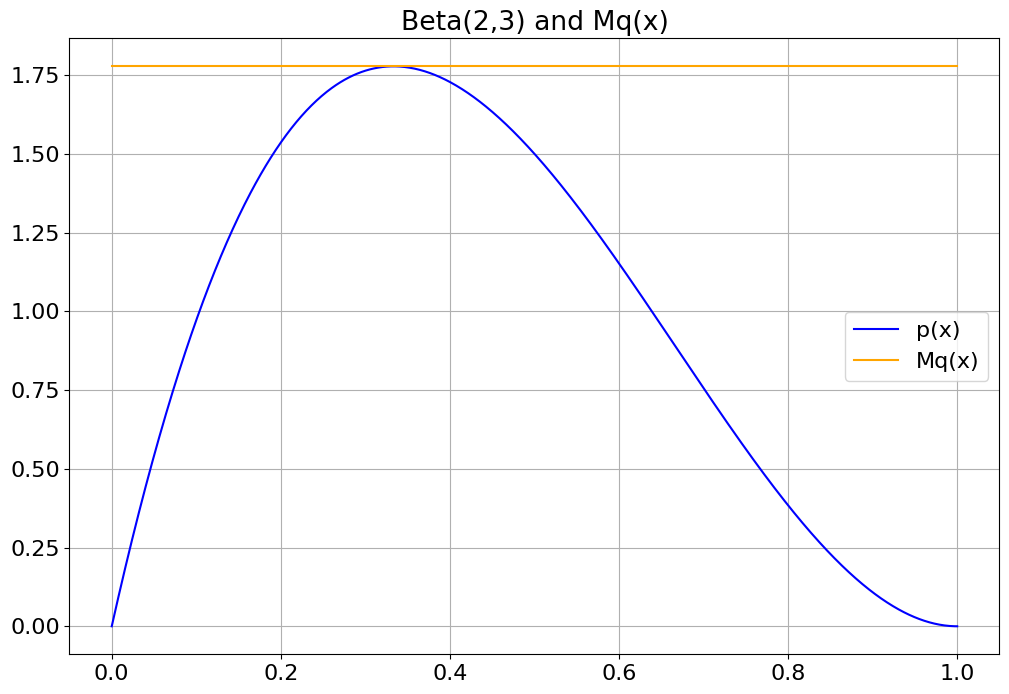

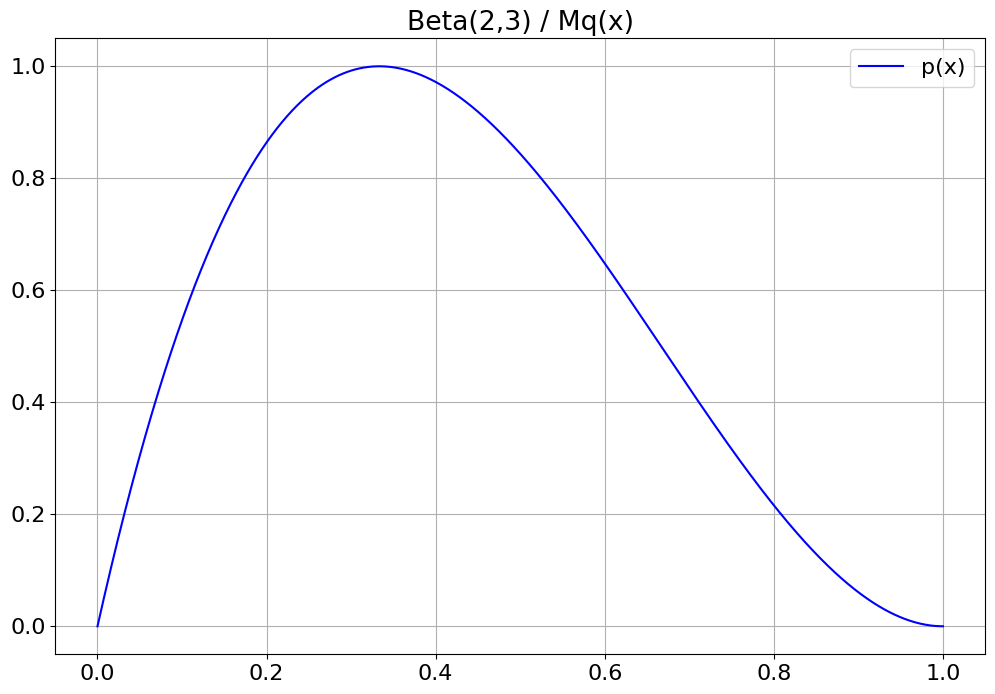

In [5]:
def beta_2_3(x):
    return 12*x * (1-x)**2

# p(x) = 12x(1-x)**2
# dp/dx = 12(3x**2 - 4x + 1)
# Local maxima at 0
# 0 = 12(3x-1)(x-1)
# Roots at 1/3 or 1
# Compute the beta at the maximum
M = beta_2_3(1/3)
M = round(M, 3)
print(f"M = {M}")
xarr = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()
sns.lineplot(
    x=xarr,
    y=beta_2_3(xarr),
    color='blue',
    label='p(x)',
    ax=ax,
)
sns.lineplot(
    x=xarr,
    y=np.repeat(1, 1000) * M,
    color='orange',
    label='Mq(x)',
    ax=ax,

)
ax.set_title("Beta(2,3) and Mq(x)")

fig, ax = plt.subplots()
sns.lineplot(
    x=xarr,
    y=beta_2_3(xarr) / (np.repeat(1, 1000) * M),
    color='blue',
    label='p(x)',
    ax=ax,
)
ax.set_title("Beta(2,3) / Mq(x)")

Acceptance rate: 0.56043


<Axes: ylabel='Density'>

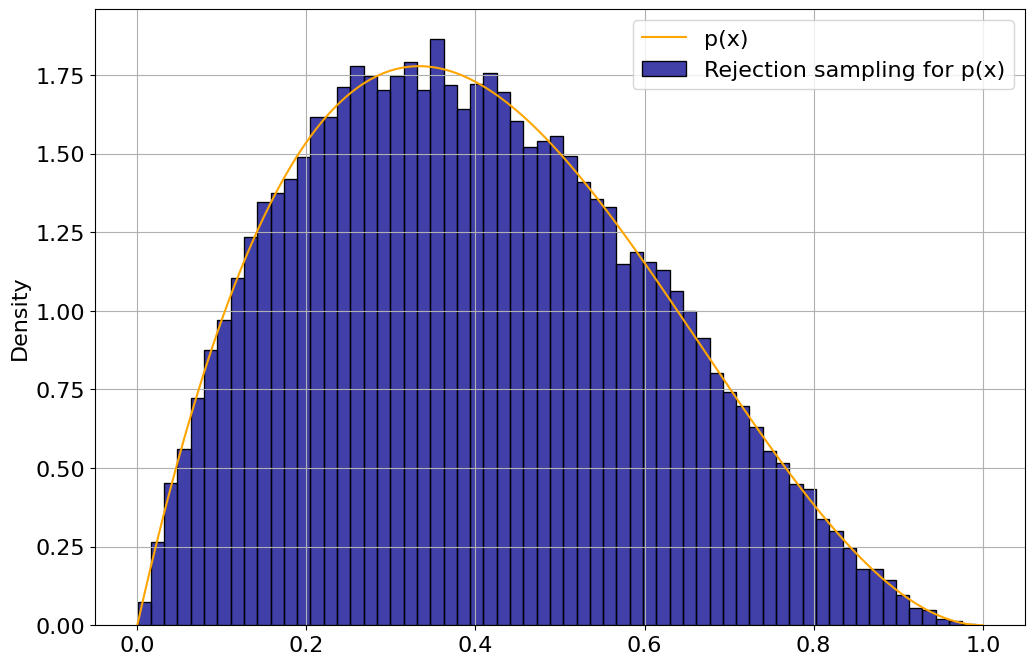

In [6]:
def rejection_sample_beta_2_3(n_draws: int = 100000) -> np.ndarray:

    x_prop = rng.uniform(0, 1, n_draws)
    u = rng.uniform(0, 1, n_draws)
    accept_samples = u*M <= beta_2_3(x_prop)
    print(f"Acceptance rate: {np.sum(accept_samples)/n_draws}")
    return x_prop[accept_samples]

accepted_samples = rejection_sample_beta_2_3(n_draws=100000)
fix, ax = plt.subplots()
sns.histplot(accepted_samples, ax=ax, stat='density', color='darkblue', label='Rejection sampling for p(x)')
sns.lineplot(x=xarr, y=beta_2_3(xarr), ax=ax, color='orange', label='p(x)')


In [7]:
e_x_5 = np.mean(rejection_sample_beta_2_3(n_draws=100_000)**5)
print(f"E[X^5] = {e_x_5}")

Acceptance rate: 0.56214
E[X^5] = 0.04799757652974275


## 5. Rejection sampling of a Gaussian with Laplace  (4 pts)

Consider the standard $\text{Laplace}(0, 1)$ distribution defined by:
$$ q(x) = 1/2 \exp(- | x | ),$$ 
and the standard normal distribution defined by
$$p(x) = \frac{1}{\sqrt{2 \pi}} \exp\left( - \frac{1}{2} x^2 \right).$$
For both the Laplace and normal distribution, $x \in (-\infty, \infty)$.

1. Write a program to draw samples from the $\text{Laplace}(0, 1)$ distribution. (*Hint*: transformation considered on Lecture 2.) Test your program by comparing the normed histogram of the samples with the density.
2. Design a method to draw samples from the standard normal using the standard Laplace distribution as the proposal. (*Hint*: you need to find a constant $M$ such that $p(x) \le M q(x)$ for all $x$. Plotting the function $p(x)/q(x)$ is again useful for looking for one.)
3. Use 10000 samples to compute the expectation $ E[x^4] $ for $ x $ following the standard normal distribution.
4. Assume the underlying uniform random generator uses full 53 bits of precision of `float64` and produces random numbers in the range $[2^{-53}, 1]$, that is the smallest number $u$ that can be generated is $2^{-53}$. Considering the same setup as above, what is the largest value the rejection sampling method can generate, if it were executed for long enough? 

Hints for part 5.4:
- You need to check that the algorithm can both generate an extreme value, and accept it.
- What's the equation for accepting a value in rejection sampling? In particular, the fact that $u$ cannot be smaller than $2^{-53}$ implies that there are some values of $x$ that you will never be able to accept. Figure out the maximum $x$ that you can accept!
- You can use the same $M$ that you used in part 5.2 (as long as you chose a reasonable $M$, the answer will be valid).

In [8]:
def laplace_inv_cdf(x: np.ndarray, mu: float, b: float):
    return mu - b * np.sign(x-0.5) * np.log(1 - 2*np.abs(x-0.5))

def laplace_pdf(x: np.ndarray, mu: float, b: float):
    return (1/(2*b)) * np.exp(-np.abs(x-mu)/b)

def gaussian_pdf(x: np.ndarray, mu: float, sigma: float):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-((x-mu)**2)/(2*sigma**2))

def draw_uniform_samples(a: float, b: float, n_draws: int = 10000) -> np.ndarray:
    return rng.uniform(a, b, n_draws)


def laplace_inv_cdf_samples(n_draws: int = 10000, mu: float = 0, b: float = 1) -> np.ndarray:
    samples = laplace_inv_cdf(
        draw_uniform_samples(0, 1, n_draws=n_draws),
        mu=mu,
        b=b
    )
    return samples


Text(0.5, 1.0, 'Laplace(0,1) distribution from uniform distribution inverse CDF')

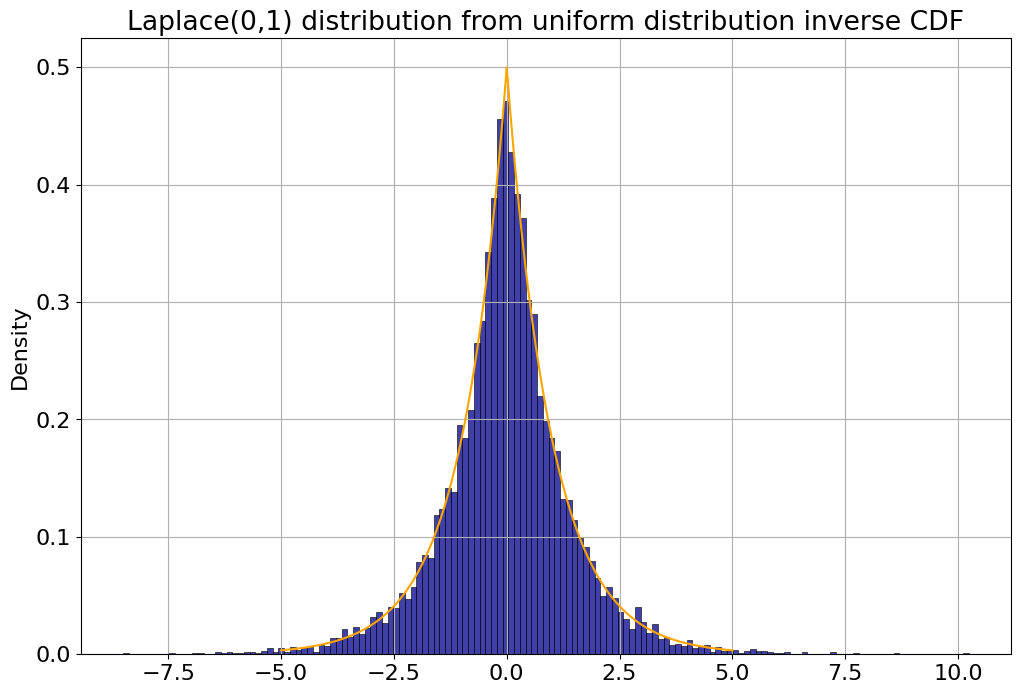

In [9]:
fig, ax = plt.subplots()
sns.histplot(
    laplace_inv_cdf_samples(n_draws=10000, mu=0, b=1), ax=ax,
    color='darkblue',
    stat='density',
)
sns.lineplot(
    x=np.linspace(-5, 5, 10000),
    y=laplace_pdf(np.linspace(-5, 5, 10000), mu=0, b=1),
    ax=ax,
    color='orange'
)
ax.set_title("Laplace(0,1) distribution from uniform distribution inverse CDF")

Text(0.5, 1.0, 'Laplace(0,1), and Gaussian(0,1) distributions. Proposal distribution scaled by 1.3333')

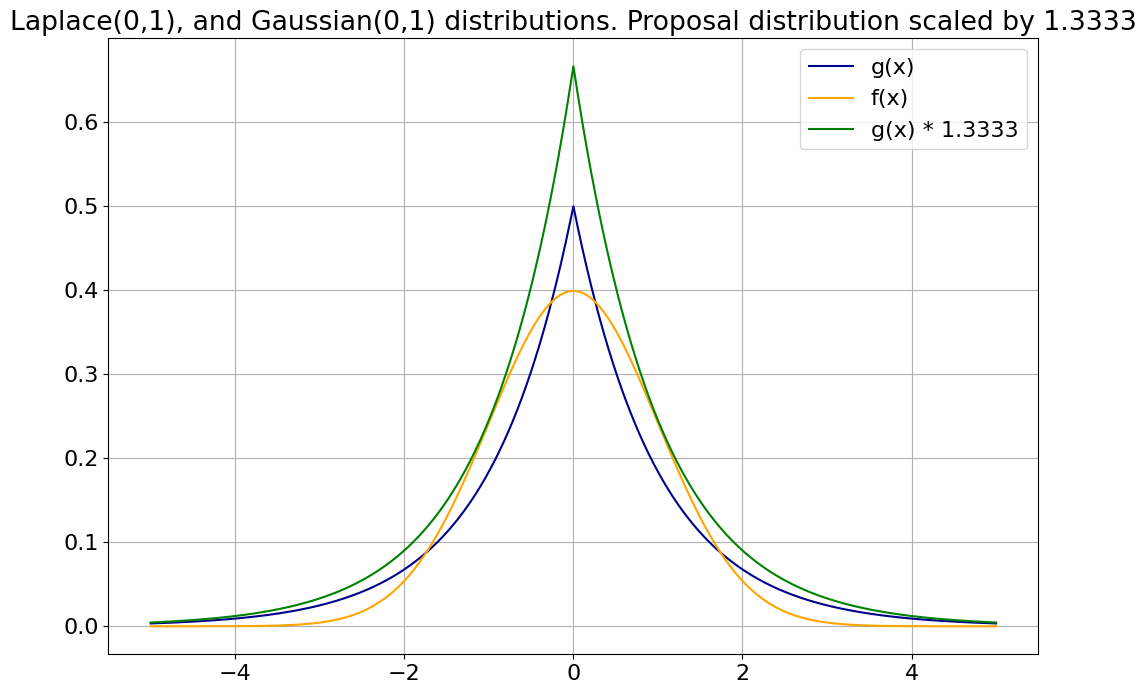

In [10]:

xarr_2 = np.linspace(-5, 5, 10000)
fig, ax = plt.subplots()
sns.lineplot(
    x=xarr_2,
    y=laplace_pdf(xarr_2, mu=0, b=1),
    ax=ax,
    color='darkblue',
    label='g(x)'
)
sns.lineplot(
    x=xarr_2,
    y=gaussian_pdf(xarr_2, mu=0, sigma=1),
    ax=ax,
    color='orange',
    label='f(x)'
)
sns.lineplot(
    x=xarr_2,
    y=laplace_pdf(xarr_2, mu=0, b=1) * 1.3333,
    ax=ax,
    color='green',
    label='g(x) * 1.3333'
)
ax.legend()
ax.set_title("Laplace(0,1), and Gaussian(0,1) distributions. Proposal distribution scaled by 1.3333")

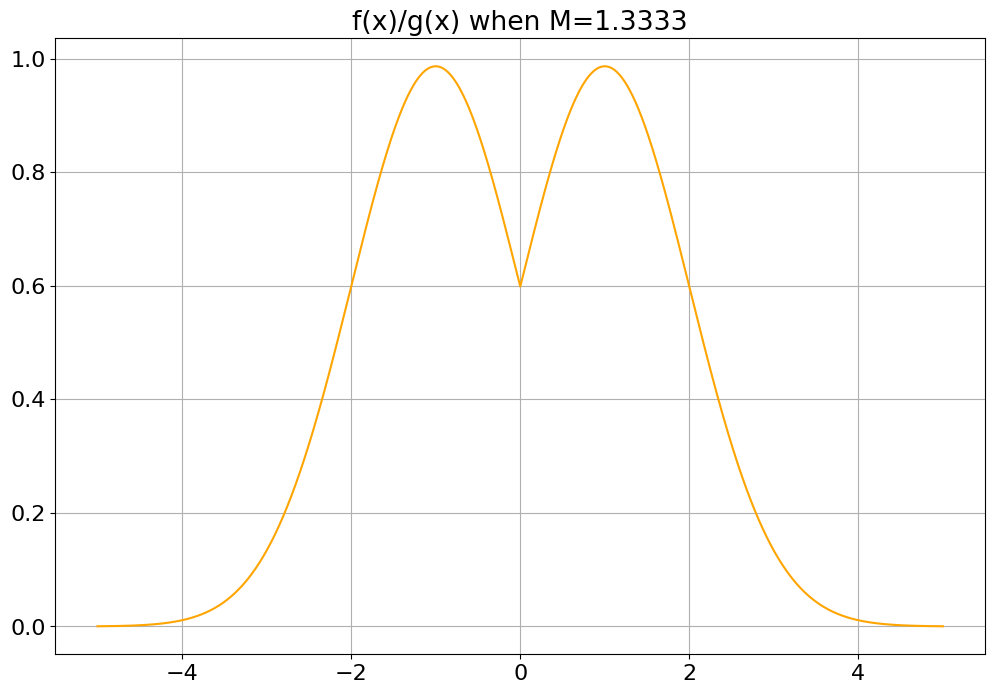

In [11]:
# finding M for gaussian(0, 1) and laplace(0, 1)
M=1.3333
fig, ax = plt.subplots()
sns.lineplot(
    x=np.linspace(-5, 5, 10000),
    y=gaussian_pdf(np.linspace(-5, 5, 10000), mu=0, sigma=1) / (M *  laplace_pdf(np.linspace(-5, 5, 10000), mu=0, b=1)),
    ax=ax,
    color='orange'
)
ax.title.set_text('f(x)/g(x) when M=1.3333')

Acceptance rate: 0.74883


<Axes: ylabel='Density'>

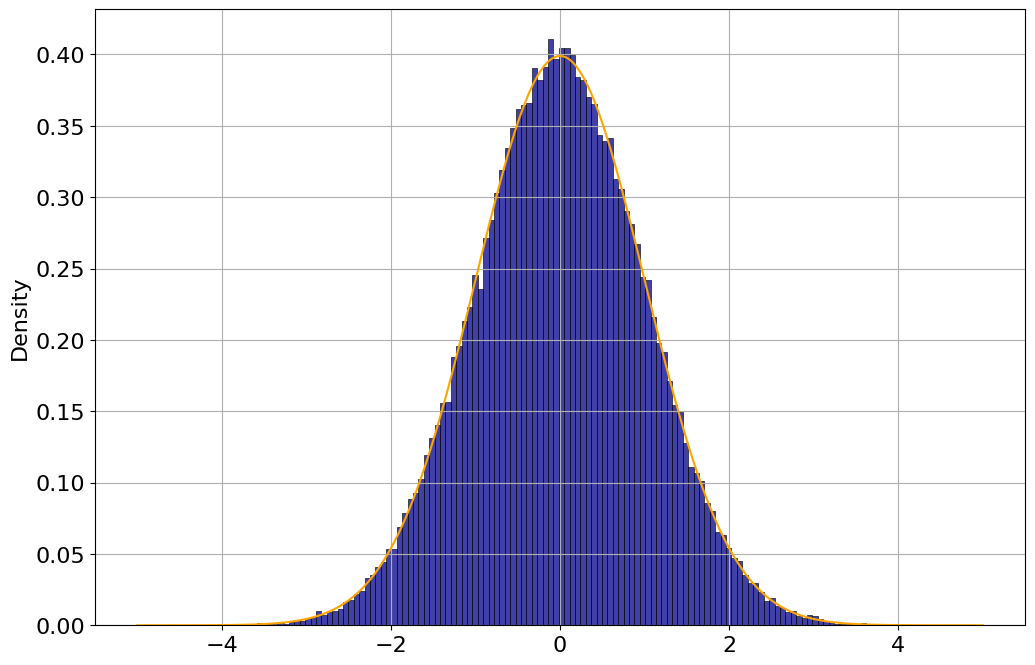

In [12]:
# do rejection sampling of gaussian
def rejection_sample_gaussian(n_draws: int = 100000, mu: float = 0, sigma: float = 1, b: float = 1, M: float = 1.3333) -> np.ndarray:
    x_proposal = laplace_inv_cdf_samples(n_draws=n_draws, mu=mu, b=b)
    u = draw_uniform_samples(0, 1, n_draws=n_draws)
    accept = (u * M * laplace_pdf(x_proposal, mu=mu, b=b)) <= gaussian_pdf(x_proposal, mu=mu, sigma=sigma)
    print(f"Acceptance rate: {accept.mean()}")
    return x_proposal[accept]

fig, ax = plt.subplots()
sns.histplot(
    rejection_sample_gaussian(n_draws=100000, mu=0, sigma=1, M=1.3333), ax=ax,
    color='darkblue',
    stat='density',
)
sns.lineplot(
    x=np.linspace(-5, 5, 10000),
    y=gaussian_pdf(np.linspace(-5, 5, 10000), mu=0, sigma=1),
    ax=ax,
    color='orange'
)

In [13]:
print(f"Expectation of E[X^5] = {np.mean(rejection_sample_gaussian(n_draws=100000, mu=0, sigma=1, M=1.3333)**5)}")

Acceptance rate: 0.74976
Expectation of E[X^5] = -0.06345135337883859


In [14]:
# finding the most extreme sample

# Part 1, finding the most extreme sample from Laplace(0,1)
import scipy


M = 1.3333
converged = False
laplace_epsilon = 1e-10
max_laplace_x = 0
while not converged:
    x = np.array([1])
    laplace_draw = laplace_inv_cdf(x-laplace_epsilon, mu=0, b=1)
    if np.isinf(laplace_draw):
        if max_laplace_x!= 0:
            converged = True
            print(f"max_laplace_x converged to {max_laplace_x}")
            break
        laplace_epsilon = laplace_epsilon * 2
    else:
        max_laplace_x = laplace_draw
        u = x - laplace_epsilon
        laplace_epsilon = laplace_epsilon / 2

# Part 2, finding the most extreme sample from Gaussian(0,1)
converged = False
gaussian_epsilon = 1e-10
max_gaussian_x = 0
gaussian_ = scipy.stats.norm(0, 1)
while not converged:
    x = np.array([1])
    gaussian_draw = gaussian_.ppf(x-gaussian_epsilon)
    if np.isinf(gaussian_draw):
        if max_gaussian_x!= 0:
            converged = True
            print(f"max_gaussian converged to {max_gaussian_x}")
            break
        gaussian_epsilon = gaussian_epsilon * 2
    else:
        max_gaussian_x = gaussian_draw
        u = x - gaussian_epsilon
        gaussian_epsilon = gaussian_epsilon / 2

# Most extreme sample is the one with the largest absolute value
accepted = np.log(1) + np.log(M) + np.log(laplace_pdf(max_laplace_x, mu=0, b=1)) <= np.log(gaussian_pdf(max_gaussian_x, mu=0, sigma=1))

print(f"Most extreme sample that can be generated and accepted with float64 is {max_laplace_x}")

max_laplace_x converged to [36.04365339]
max_gaussian converged to [8.20953615]
Most extreme sample that can be generated and accepted with float64 is [36.04365339]


/var/folders/h7/h1t9twn9577g_ykyc9r8cprr0000gn/T/ipykernel_49587/3414481746.py:2: RuntimeWarning: divide by zero encountered in log
  return mu - b * np.sign(x-0.5) * np.log(1 - 2*np.abs(x-0.5))
